## Imports

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import time
import random
import copy
from matplotlib import pyplot as plt
from collections import namedtuple

## Hyperparameters and other constants

In [2]:
SEED = 89
GAMMA = 0.995
MEMORY_SIZE = 1000000
ACTOR_LEARNING_RATE = 0.001
CRITIC_LEARNING_RATE = 0.001
ACTOR_LAYER_SIZES = [128, 64, 32, 16]
CRITIC_LAYER_SIZES = [512, 64, 32, 16]
BATCH_SIZE = 256
NUMBER_OF_EPISODES = 10000
TAU = 0.00025
GOAL_SCORE = 0.5
EPSILON = 1
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01
TRAIN_STEPS = 2
ENV_PATH = 'Tennis_Windows_x86_64/Tennis.exe'
ACTOR_1_PATH = 'actor1.pth'
CRITIC_1_PATH = 'critic1.pth'
ACTOR_2_PATH = 'actor2.pth'
CRITIC_2_PATH = 'critic2.pth'

## Auxiliar functions

Auxiliar functions used in the main program

In [3]:
# If GPU is available, use it for trainining the agent's DQN
def get_default_device():
    if torch.cuda.is_available():
        print('CUDA is available. Training on GPU.')
        return torch.device('cuda')
    else:
        print('CUDA is not available. Training on CPU.')
        return torch.device('cpu')

# Create Unity environment
def create_environment(train_mode, path_to_env):
    env = UnityEnvironment(file_name=path_to_env)
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=train_mode)[brain_name]
    state_size = len(env_info.vector_observations[0])
    action_size = brain.vector_action_space_size
    num_agents = len(env_info.agents)
    return env, env_info, brain_name, state_size, action_size, num_agents

## Class ReplayMemory

Memory of transitions for experience replay.

In [4]:
class ReplayMemory:

    # Create replay memory
    def __init__(self, num_agents, state_size, action_size, seed):
        self.states = np.zeros((MEMORY_SIZE, num_agents, state_size))
        self.states_next = np.zeros((MEMORY_SIZE, num_agents, state_size))
        self.actions = np.zeros((MEMORY_SIZE, num_agents, action_size))
        self.rewards = np.zeros((MEMORY_SIZE, num_agents))
        self.terminal_states = np.zeros((MEMORY_SIZE, num_agents))
        self.current_size = 0
        np.random.seed(seed)

    # Store a transition (s,a,r,s') in the replay memory
    def store_transition(self, state, action, reward, state_next, terminal_state):
        i = self.current_size
        self.states[i] = state
        self.actions[i] = action
        self.rewards[i] = reward
        self.states_next[i] = state_next
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1

        if self.current_size >= MEMORY_SIZE - 1:
            self.current_size = 0

    # Generate a random sample of transitions from the replay memory
    def sample_memory(self, num_agents, batch_size):
        Experience = namedtuple('Experience', ['states', 'actions', 'rewards', 'states_next', 'terminal_states'])
        experiences = Experience(states=[], actions=[], rewards=[], states_next=[], terminal_states=[])

        for i in range(num_agents):
            batch = np.random.choice(self.current_size, batch_size)
            experiences.states.append(torch.from_numpy(self.states[batch]).float().to(device))
            experiences.actions.append(torch.from_numpy(self.actions[batch]).float().to(device))
            experiences.rewards.append(torch.from_numpy(self.rewards[batch]).float().to(device))
            experiences.states_next.append(torch.from_numpy(self.states_next[batch]).float().to(device))
            experiences.terminal_states.append(torch.from_numpy(self.terminal_states[batch].astype(np.uint8)).float().to(device))

        return experiences

## Class OUNoise

Ornstein-uhlenbeck noise to add some exploration to the agent.

In [5]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size  # num agents added
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.state = None
        random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

## Classes Actor & Critic

Actor and critic models

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):

    # Create neural network
    def __init__(self, state_size, action_size, layer_sizes, seed):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer_1 = nn.Linear(state_size, layer_sizes[0])
        self.batch_norm_1 = nn.BatchNorm1d(layer_sizes[0])
        self.layer_2 = nn.Linear(layer_sizes[0], layer_sizes[1])
        self.batch_norm_2 = nn.BatchNorm1d(layer_sizes[1])
        self.layer_3 = nn.Linear(layer_sizes[1], layer_sizes[2])
        self.batch_norm_3 = nn.BatchNorm1d(layer_sizes[2])
        self.layer_4 = nn.Linear(layer_sizes[2], layer_sizes[3])
        self.batch_norm_4 = nn.BatchNorm1d(layer_sizes[3])
        self.layer_5 = nn.Linear(layer_sizes[3], action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.layer_1.weight.data.uniform_(*hidden_init(self.layer_1))
        self.layer_2.weight.data.uniform_(*hidden_init(self.layer_2))
        self.layer_3.weight.data.uniform_(*hidden_init(self.layer_3))
        self.layer_4.weight.data.uniform_(*hidden_init(self.layer_4))
        self.layer_5.weight.data.uniform_(-3e-3, 3e-3)

    # Forward pass
    def forward(self, state):
        x = torch.nn.functional.relu(self.batch_norm_1(self.layer_1(state)))
        x = torch.nn.functional.relu(self.batch_norm_2(self.layer_2(x)))
        x = torch.nn.functional.relu(self.batch_norm_3(self.layer_3(x)))
        x = torch.nn.functional.relu(self.batch_norm_4(self.layer_4(x)))
        x = torch.tanh(self.layer_5(x))

        return x

class Critic(nn.Module):

    # Create neural network
    def __init__(self, num_agents, state_size, action_size, layer_sizes, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer_1 = nn.Linear((state_size+action_size)*num_agents, layer_sizes[0])
        self.batch_norm_1 = nn.BatchNorm1d(layer_sizes[0])
        self.layer_2 = nn.Linear(layer_sizes[0], layer_sizes[1])
        self.batch_norm_2 = nn.BatchNorm1d(layer_sizes[1])
        self.layer_3 = nn.Linear(layer_sizes[1], layer_sizes[2])
        self.batch_norm_3 = nn.BatchNorm1d(layer_sizes[2])
        self.layer_4 = nn.Linear(layer_sizes[2], layer_sizes[3])
        self.batch_norm_4 = nn.BatchNorm1d(layer_sizes[3])
        self.layer_5 = nn.Linear(layer_sizes[3], 1)
        self.reset_parameters()

    # Weight initialization
    def reset_parameters(self):
        self.layer_1.weight.data.uniform_(*hidden_init(self.layer_1))
        self.layer_2.weight.data.uniform_(*hidden_init(self.layer_2))
        self.layer_3.weight.data.uniform_(*hidden_init(self.layer_3))
        self.layer_4.weight.data.uniform_(*hidden_init(self.layer_4))
        self.layer_5.weight.data.uniform_(-3e-3, 3e-3)

    # Forward pass
    def forward(self, state, action):
        x = torch.cat((state, action), dim=2)
        x = x.permute(1, 0, 2).contiguous().view(x.size(1), -1)
        x = torch.nn.functional.relu(self.batch_norm_1(self.layer_1(x)))
        x = torch.nn.functional.relu(self.batch_norm_2(self.layer_2(x)))
        x = torch.nn.functional.relu(self.batch_norm_3(self.layer_3(x)))
        x = torch.nn.functional.relu(self.batch_norm_4(self.layer_4(x)))
        x = self.layer_5(x)

        return x

## Class Agent

DDPG agent with actor and critic networks, as well as their respective target networks.


In [7]:
class Agent:

    # Create DDPG agent
    def __init__(self, id, num_agents, state_size, action_size, seed):
        self.id = id
        self.state_size = state_size
        self.action_size = action_size
        self.scores = []
        self.noise = OUNoise((1, action_size), seed)
        self.actor_local = Actor(state_size, action_size, ACTOR_LAYER_SIZES, seed).to(device)
        self.actor_target = Actor(state_size, action_size, ACTOR_LAYER_SIZES, seed).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor_local.parameters(), lr=ACTOR_LEARNING_RATE)
        self.deep_copy(self.actor_local, self.actor_target)
        self.critic_local = Critic(num_agents, state_size, action_size, CRITIC_LAYER_SIZES, seed).to(device)
        self.critic_target = Critic(num_agents, state_size, action_size, CRITIC_LAYER_SIZES, seed).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic_local.parameters(), lr=CRITIC_LEARNING_RATE)
        self.deep_copy(self.critic_local, self.critic_target)


    # Select action following the current policy
    def act(self, state, exploration, add_noise=True):
        state = torch.from_numpy(state).float().to(device).unsqueeze(0)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()

        if add_noise:
            action += exploration * self.noise.sample()

        return np.clip(action, -1, 1)

    # Update policy and value function.
    def learn(self, agent_id, states, actions, rewards, next_states, terminal_states, all_actions_predicted, all_next_actions):

        # ------------------ CRITIC TRAINING ------------------
        # Predict next actions and their Q values using target networks
        agent_id = torch.tensor([agent_id]).to(device)
        with torch.no_grad():
            q_targets_next = self.critic_target(next_states, all_next_actions)
        # Compute Q targets for current state
        q_targets = rewards.index_select(1, agent_id) + (GAMMA * q_targets_next * (1 - terminal_states.index_select(1, agent_id)))
        # Compute actual q value for current states and actions
        q_expected = self.critic_local(states, actions)
        # Compute critic loss and minimize it
        critic_loss = nn.functional.mse_loss(q_expected, q_targets.detach())
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ------------------ ACTOR TRAINING ------------------
        # Compute actor loss (we need to detach other agents actions)
        actions_predicted = [action if i == self.id else action.detach() for i, action in enumerate(all_actions_predicted)]
        actions_predicted = torch.stack(actions_predicted)
        actor_loss = -self.critic_local(states, actions_predicted).mean()
        # Minimize it
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ------------------ SOFT UPDATING ------------------
        self.soft_update(self.actor_local, self.actor_target, TAU)
        self.soft_update(self.critic_local, self.critic_target, TAU)

    # Soft update a target network
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    # Exact copy to ensure same weights
    def deep_copy(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data)


In [8]:
class MultiAgent:

    # Create multi agent composed of DDPG agents sharing one single memory
    def __init__(self, num_agents, state_size, action_size, seed):
        self.num_agents = num_agents
        self.agents = [Agent(i, num_agents, state_size, action_size, seed) for i in range(self.num_agents)]
        self.memory = ReplayMemory(self.num_agents, state_size, action_size, seed)
        self.epsilon = EPSILON
        self.epsilon_decay = EPSILON_DECAY
        self.epsilon_min = EPSILON_MIN
        self.scores = []


    # Store a tuple (s, a, r, s') for experience replay
    def remember(self, state, action, reward, next_state, terminal_state):
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    # Select action using one agent
    def act(self, states, add_noise=True):
        actions = []
        for agent, state in zip(self.agents, states):
            action = agent.act(state, self.epsilon, add_noise)
            actions.append(action)

        return actions

    # Perform an action over the environment
    def step(self, action, brain_name, env):
        env_info = env.step(action)[brain_name]
        reward = env_info.rewards
        next_state = env_info.vector_observations
        terminal_state = env_info.local_done
        return reward, next_state, terminal_state

    # Update all agents' weights
    def learn(self):
        if self.memory.current_size < BATCH_SIZE: return

        experiences = self.memory.sample_memory(self.num_agents, BATCH_SIZE)
        all_predicted_actions = []
        all_next_actions = []

        for i, agent in enumerate(self.agents):
            states = experiences.states[i]
            states_next = experiences.states_next[i]
            states = torch.unbind(states, dim=1)
            states_next = torch.unbind(states_next, dim=1)
            all_predicted_actions.append(agent.actor_local(states[agent.id]))
            all_next_actions.append(agent.actor_target(states_next[agent.id]))

        all_next_actions = torch.stack(all_next_actions)

        for i, agent in enumerate(self.agents):
            states = experiences.states[i]
            actions = experiences.actions[i]
            rewards = experiences.rewards[i]
            states_next = experiences.states_next[i]
            terminal_states = experiences.terminal_states[i]

            states = torch.stack(torch.unbind(states, dim=1))
            states_next = torch.stack(torch.unbind(states_next, dim=1))
            actions = actions.permute(1,0,2)

            agent.learn(i, states, actions, rewards, states_next, terminal_states, all_predicted_actions, all_next_actions)

    # Add the obtained score in a list to be presented later
    def add_score(self, score):
        self.scores.append(score)

    # Display the obtained scores graphically
    def display_scores_graphically(self):
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")

## Main program

CUDA is not available. Training on CPU.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Episode   1:   average score 0.0   exploration 0.995   transitions: 15)  score:  0.0 
Episode   2:   average score 0.0   exploration 0.990025   transitions: 32)  score:  0.0 
Episode   3:   average score 0.0   exploration 0.985074875   transitions: 50)  score:  0.0 
Episode   4:   average score 0.0   exploration 0.9801495006250001   transitions: 64)  score:  0.0 
Episode   5:   average score 0.0   exploration 0.9752487531218751   transitions: 79)  score:  0.0 
Episode   6:   average score 0.016666666915019352   exploration 0.9703725093562657   transitions: 111)  score:  0.10000000149011612 
Episode   7:   average score 0.014285714498588018   exploration 0.9655206468094844   transitions: 126)  score:  0.0 
Episode   8:   average score 0.012500000186264515   exploration 0.960693043575437   transitions: 140)  score:  0.0 
Episode   9:   average score 0.011111111276679568   exploration 0.9558895783575597   transitions: 154)  score:  0.0 
Episode  10:   average score 0.010000000149011612   

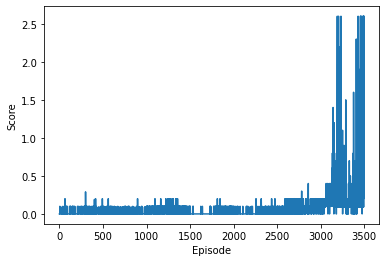

In [9]:
# Checking if GPU is available
device = get_default_device()

env, env_info, brain_name, state_size, action_size, num_agents = create_environment(True, ENV_PATH)
multi_agent = MultiAgent(num_agents, state_size, action_size, SEED)
scores = []
goal_reached = False
episode = 0
total_steps = 1
start_time = time.perf_counter()

while (episode < NUMBER_OF_EPISODES) and not goal_reached:
    episode += 1
    step = 1
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    for agent in multi_agent.agents:
        agent.noise.reset()
    end_episode = False
    episode_rewards = []
    while not end_episode:
        # Perform an action for the current state, execute the action, retrieve env info, store transition into memory and learn from passed experiences
        actions = multi_agent.act(states)
        reward, next_states, terminal_state = multi_agent.step(actions, brain_name, env)
        multi_agent.remember(states, actions, reward, next_states, terminal_state)
        episode_rewards.append(reward)
        if total_steps % TRAIN_STEPS == 0:
            multi_agent.learn()

        # Detect end of episode
        if np.any(terminal_state):
            episode_reward = np.max(np.sum(np.array(episode_rewards), axis=0))
            multi_agent.add_score(episode_reward)
            scores.append(episode_reward)
            multi_agent.epsilon *= multi_agent.epsilon_decay
            multi_agent.epsilon = max(multi_agent.epsilon_min, multi_agent.epsilon)
            if episode < 100:
                avg_score = sum(scores) / len(scores)
            else:
                avg_score = sum(scores[-100:]) / 100
            if avg_score >= GOAL_SCORE:
                goal_reached = True
            print("Episode {0:>3}: ".format(episode),
                  " average score {0:>3} ".format(avg_score),
                  " exploration {0:>3} ".format(multi_agent.epsilon),
                  " transitions: " + str(multi_agent.memory.current_size) + ")",
                  " score: ", episode_reward, '\r')
            end_episode = True
        else:
            states = next_states
            step += 1
            total_steps += 1


env.close()

# Printing some info
if goal_reached:
    print("Reached goal sucessfully.")
    torch.save(multi_agent.agents[0].actor_local.state_dict(), ACTOR_1_PATH)
    torch.save(multi_agent.agents[0].critic_local.state_dict(), CRITIC_1_PATH)
    torch.save(multi_agent.agents[1].actor_local.state_dict(), ACTOR_2_PATH)
    torch.save(multi_agent.agents[1].critic_local.state_dict(), CRITIC_2_PATH)

else:
    print("Failure to reach the goal.")

print("Time:", round((time.perf_counter() - start_time) / 60), "minutes")

multi_agent.display_scores_graphically()
